In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [57]:
def process_leveraged_data(tickers, leverage_scalars, portfolio_weights):
    """
    Download historical data for given tickers, simulate leveraged ETF data, 
    and calculate their weighted contributions to the portfolio.

    Parameters:
        tickers (list of str): List of ticker symbols (e.g., ["QQQ", "SPY"]).
        leverage_scalars (list of float): List of scalars for leveraged equity returns (e.g., [3, 1]).
        portfolio_weights (list of float): List of portfolio weights for each ticker; must sum to 1 (e.g., [.2, .8]).

    Returns:
        pd.DataFrame: DataFrame with formatted columns for each ticker and weighted portfolio returns.
    """
    if len(tickers) != len(leverage_scalars) or len(tickers) != len(portfolio_weights): # Check if there is a leverage_scalars & portfolio_weight for each ticker
        raise ValueError("The number of tickers, leverage scalars, and portfolio weights must match.")
    
    if not abs(sum(portfolio_weights) - 1.0) < 1e-6: # Check if portfolio_weights sums to 1
        raise ValueError("Portfolio weights must sum to 1.")

    # Find the latest first date across all tickers
    start_date = None
    for ticker in tickers:
        ticker_data = yf.download(ticker, progress=False)
        earliest_date = ticker_data.index.min()
        if start_date is None or earliest_date > start_date:
            start_date = earliest_date

    result_df = pd.DataFrame()  # Initialize an empty DataFrame for results

    for ticker, scalar, weight in zip(tickers, leverage_scalars, portfolio_weights):
        print(f"Downloading data for {ticker}...")

        # Download the baseline data
        baseline_data = yf.download(ticker, progress=False)

        # Drop rows before the latest start date
        baseline_data = baseline_data[baseline_data.index >= start_date]
        baseline_data = baseline_data.copy() # Make copy to stop slicing issues

        # Calculate daily returns
        baseline_data['Daily Return'] = baseline_data['Adj Close'].pct_change()

        # Simulate leveraged returns based on the scalar
        baseline_data['Leveraged Return'] = baseline_data['Daily Return'] * scalar
        baseline_data.loc[baseline_data.index[0], 'Leveraged Return'] = 0  # Ensure the first leveraged return is 0

        # Weighted leveraged return
        baseline_data['Weighted Leveraged Return'] = baseline_data['Leveraged Return'] * weight

        # Calculate simulated leveraged price
        baseline_data['Simulated Leveraged Price'] = (1 + baseline_data['Weighted Leveraged Return']).cumprod()
        baseline_data['Simulated Leveraged Price'] *= baseline_data['Adj Close'].iloc[0]  # Normalize to starting price

        # Rename columns to include the ticker symbol
        baseline_data = baseline_data.rename(
            columns={
                'Daily Return': f'DailyReturn_{ticker}',
                'Adj Close': f'AdjClose_{ticker}',
                'Leveraged Return': f'LeveragedReturn_{ticker}_{scalar}X',
                'Simulated Leveraged Price': f'SimulatedLeveragedPrice_{ticker}_{scalar}X',
                'Weighted Leveraged Return': f'WeightedLeveragedReturn_{ticker}_{scalar}X'
            }
        )

        # Keep only relevant columns and reset index
        baseline_data = baseline_data[[f'DailyReturn_{ticker}', f'AdjClose_{ticker}', 
                                       f'LeveragedReturn_{ticker}_{scalar}X', f'SimulatedLeveragedPrice_{ticker}_{scalar}X', 
                                       f'WeightedLeveragedReturn_{ticker}_{scalar}X']]
        
        baseline_data.reset_index(inplace=True)

        # Merge with the result DataFrame
        if result_df.empty:
            result_df = baseline_data
        else:
            result_df = pd.merge(result_df, baseline_data, on='Date', how='outer')

    # Calculate total portfolio returns
    weighted_columns_1 = [col for col in result_df.columns if col.startswith('LeveragedReturn')]
    result_df['TotalPortfolioReturn'] = result_df[weighted_columns_1].sum(axis=1)
    # Calculate total portfolio price
    weighted_columns_2 = [col for col in result_df.columns if col.startswith('SimulatedLeveragedPrice')]
    result_df['TotalPortfolioPrice'] = result_df[weighted_columns_2].sum(axis=1)

    # Grab the columns of importance
    #result_df = result_df[['']]

    return result_df.dropna()

In [58]:
# Define inputs
tickers = ["QQQ", "SPY", "SOXX"]
leverage_scalars = [3, 3, 3]  # Leverage scalars for each respective ticker
portfolio_weights = [0.6, 0.2, 0.2]  # Portfolio weights summing to 1.0

# Process the data
data = process_leveraged_data(tickers, leverage_scalars, portfolio_weights)
data.head()

,Date,DailyReturn_QQQ,AdjClose_QQQ,LeveragedReturn_QQQ_3X,SimulatedLeveragedPrice_QQQ_3X,WeightedLeveragedReturn_QQQ_3X,DailyReturn_SPY,AdjClose_SPY,LeveragedReturn_SPY_3X,SimulatedLeveragedPrice_SPY_3X,WeightedLeveragedReturn_SPY_3X,DailyReturn_SOXX,AdjClose_SOXX,LeveragedReturn_SOXX_3X,SimulatedLeveragedPrice_SOXX_3X,WeightedLeveragedReturn_SOXX_3X,TotalPortfolioReturn,TotalPortfolioPrice
1,2001-07-16,-0.018540,35.951263,-0.055621,35.407950,-0.033373,-0.012516,78.173256,-0.037549,78.569597,-0.007510,-0.057949,18.885534,-0.173847,19.350221,-0.034769,-0.267017,133.327768
2,2001-07-17,0.022432,36.757736,0.067297,36.837663,0.040378,0.009361,78.905052,0.028084,79.010901,0.005617,0.041058,19.660929,0.123173,19.826905,0.024635,0.218554,135.675468
3,2001-07-18,-0.038106,35.357044,-0.114318,34.310935,-0.068591,-0.006812,78.367531,-0.020437,78.687955,-0.004087,-0.041403,18.846901,-0.124210,19.334365,-0.024842,-0.258965,132.333255
4,2001-07-19,0.023769,36.197456,0.071308,35.778919,0.042785,0.008759,79.053970,0.026278,79.101503,0.005256,0.042460,19.647137,0.127379,19.826925,0.025476,0.224965,134.707347
5,2001-07-20,-0.023217,35.357044,-0.069652,34.283669,-0.041791,-0.005980,78.581261,-0.017939,78.817707,-0.003588,-0.004916,19.550554,-0.014748,19.768445,-0.002950,-0.102339,132.869821


In [14]:
def find_ath_indices(data, column, window=0):
    """
    Find indices where the column reaches a new all-time high and optionally expand indices by window of days.
    
    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to evaluate for all-time highs.
        Similarly, as mentioned above, we can examine the spread across multiple windows. (int): Number of days to expand the indices by (± window). Default is 0.
    
    Returns:
        list: List of indices where a new all-time high is set, optionally expanded.
    """
    ath_indices = []
    current_ath = -9999
    
    # Find new all-time highs
    for idx, value in data[column].items():
        if value > current_ath:
            current_ath = value
            ath_indices.append(idx)
    
    # Expand indices if window > 0
    if window > 0:
        expanded_indices = set()
        for idx in ath_indices:
            for offset in range(-window, window + 1):  # ±window range
                new_idx = idx + offset
                if 0 <= new_idx < len(data):  # Ensure within bounds
                    expanded_indices.add(new_idx)
        ath_indices = sorted(expanded_indices)
    
    return ath_indices

In [66]:
def calculate_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730, # 2 Years
        'Return_48M': 1460, # 4 Years
    }
    
    results = []
    for idx in ath_indices:
        row = {'ATH_Index': idx, 'Date': data.loc[idx, 'Date']}
        for period_name, holding_period in holding_periods.items():
            if idx + holding_period < len(data):
                entry_price = data['TotalPortfolioPrice'].iloc[idx]
                exit_price = data['TotalPortfolioPrice'].iloc[idx + holding_period]
                return_pct = (exit_price - entry_price) / entry_price
                row[period_name] = return_pct
            else:
                row[period_name] = None  # Handle cases where holding period exceeds data length

        results.append(row)
    return pd.DataFrame(results)




def calculate_non_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730, # 2 Years
        'Return_48M': 1460, # 4 Years
    }
    
    results = []

    for idx in data.index:
        if idx not in ath_indices:  # Exclude ATH indices
            row = {'Index': idx, 'Date': data.loc[idx, 'Date']}
            for period_name, holding_period in holding_periods.items():
                if idx + holding_period < len(data):  # Ensure holding period is valid
                    entry_price = data['TotalPortfolioPrice'].iloc[idx]
                    exit_price = data['TotalPortfolioPrice'].iloc[idx + holding_period]
                    return_pct = (exit_price - entry_price) / entry_price
                    row[period_name] = return_pct
                else:
                    row[period_name] = None  # Handle cases where holding period exceeds data length
            
            results.append(row)
    return pd.DataFrame(results)


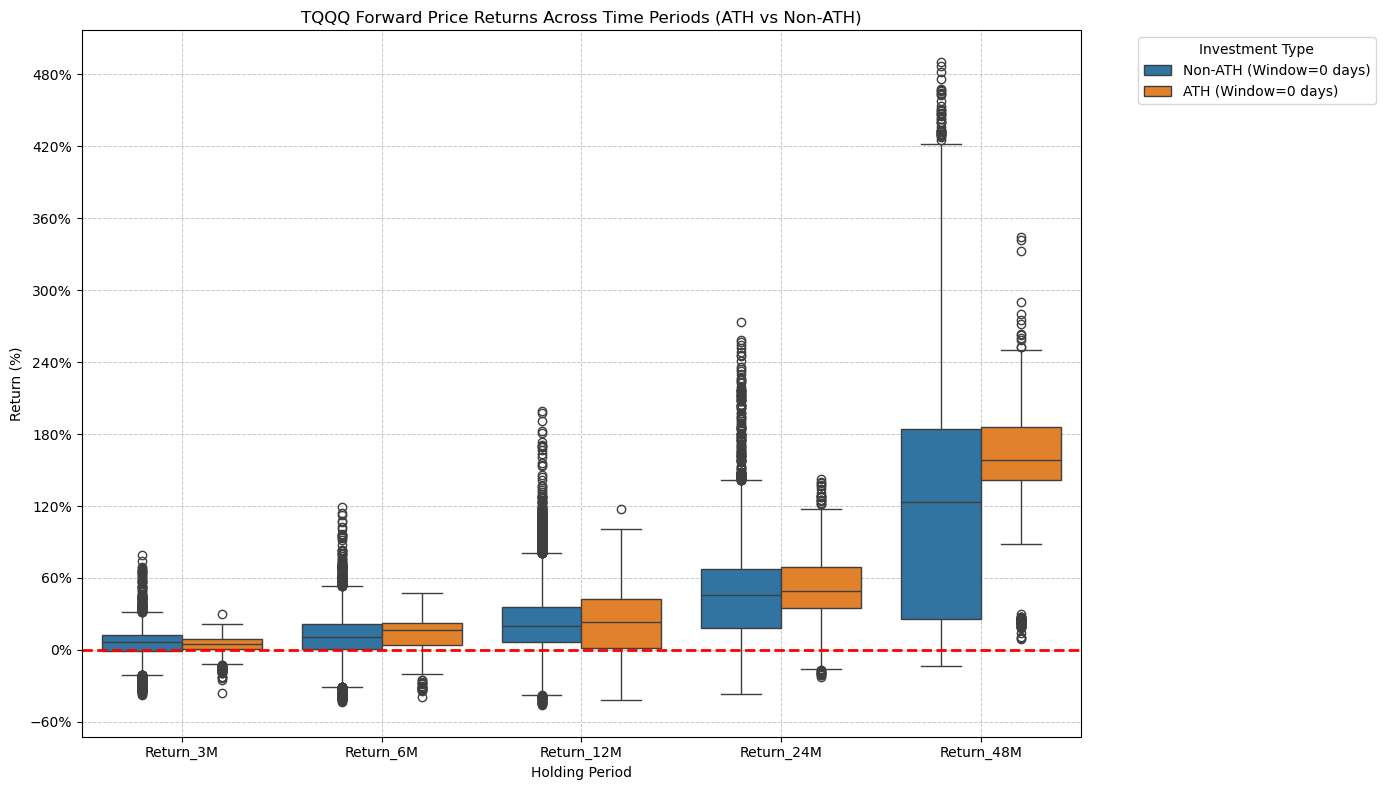

In [76]:
# Window sizes
windows = [0]#[0, 5, 15, 30, 50, 75]
combined_results = []
for w in windows:
    ############### this is now only lookin at when our portfolio is at an ath. Maybe change this?   #############
    ath_indices_leveraged = find_ath_indices(data, 'TotalPortfolioPrice', window=w)

    # ATH returns
    ath_returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
    non_ath_returns_df = calculate_non_ath_returns_all_periods(data, ath_indices_leveraged)

    # Add group flag
    ath_returns_df['Group'] = f'ATH (Window={w} days)'
    if w == 0:
        non_ath_returns_df['Group'] = 'Non-ATH (Window=0 days)'
        combined_results.append(non_ath_returns_df)  # Only include non-ATH data for Window=0

    # Combine results
    combined_results.append(ath_returns_df)

# # Join to a single df
final_combined_df = pd.concat(combined_results)

# Melt DataFrame for the two groups & their holding periods
melted_df = final_combined_df.melt(
    id_vars=['Group'], 
    value_vars=['Return_3M', 'Return_6M', 'Return_12M', 'Return_24M', 'Return_48M'], 
    var_name='Holding Period', 
    value_name='Return'
)

# Create boxplots
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=melted_df, 
    x='Holding Period', 
    y='Return', 
    hue='Group', 
    palette='tab10'
)

from matplotlib.ticker import PercentFormatter, MaxNLocator
# Customize plot aesthetics
plt.title('TQQQ Forward Price Returns Across Time Periods (ATH vs Non-ATH)')
plt.xlabel('Holding Period')
plt.ylabel('Return (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # y-axis as percentages
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))  # Add more ticks on the y-axis
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Add a grid
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Add a baseline for 0% return
plt.legend(title='Investment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
